In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline


In [2]:
from fastai.vision import *
from fastai.callbacks.hooks import *
from fastai.utils.mem import *

In [3]:
gpu_mem_get_all()

[GPUMemory(total=11018, free=10771, used=247)]

In [4]:
gpu_mem_get_free_no_cache()
path = untar_data('data/Smoke_segmentation')
path.ls()


[PosixPath('/home/sahand/Smoke_detection/data/Smoke_segmentation/training.zip'),
 PosixPath('/home/sahand/Smoke_detection/data/Smoke_segmentation/images'),
 PosixPath('/home/sahand/Smoke_detection/data/Smoke_segmentation/training'),
 PosixPath('/home/sahand/Smoke_detection/data/Smoke_segmentation/seg_aug'),
 PosixPath('/home/sahand/Smoke_detection/data/Smoke_segmentation/gt_training.zip'),
 PosixPath('/home/sahand/Smoke_detection/data/Smoke_segmentation/masks'),
 PosixPath('/home/sahand/Smoke_detection/data/Smoke_segmentation/Frames'),
 PosixPath('/home/sahand/Smoke_detection/data/Smoke_segmentation/gt_training'),
 PosixPath('/home/sahand/Smoke_detection/data/Smoke_segmentation/test')]

In [5]:
gpu_mem_get_all()

[GPUMemory(total=11018, free=10771, used=247)]

In [47]:
mask_train_path= path/'gt_training'
train_path = path/'training'
test_images = path/'test'

In [48]:
# From: https://forums.fast.ai/t/cant-do-segmentation-cuda-error-device-side-assert-triggered/37507/5?u=andandandand
class SegLabelListCustom(SegmentationLabelList):
    def open(self, fn): return open_mask(fn, div=True)

class SegItemListCustom(SegmentationItemList):
    _label_cls = SegLabelListCustom

In [49]:
fnames = get_image_files(train_path)
mask_names = get_image_files(mask_train_path)
gpu_mem_get_all()

[GPUMemory(total=11018, free=9216, used=1801)]

In [51]:
len(mask_names)

256

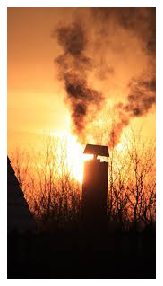

In [9]:
img_f = fnames[2]
img = open_image(img_f)
img.show(figsize=(5,5))

In [10]:
get_y_fn = lambda x :mask_train_path / f'{x.stem}{x.suffix}' # Fixed
gpu_mem_get_free_no_cache()
gpu_mem_get_all()

[GPUMemory(total=11018, free=10771, used=247)]

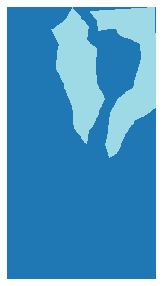

In [11]:
mask = open_mask(get_y_fn(img_f))
mask.show(figsize=(5,5), alpha=1)

In [12]:
src_size = np.array(mask.shape[1:])
gpu_mem_get_all()

[GPUMemory(total=11018, free=10771, used=247)]

In [13]:
codes =['No-Smoke', 'smoke']

In [14]:
size = src_size//2


In [15]:
bs = 6

In [16]:
gpu_mem_get_all()

[GPUMemory(total=11018, free=10771, used=247)]

In [17]:
free = gpu_mem_get_free_no_cache()
data = (SegItemListCustom.from_folder(train_path)
        #Where to find the data? -> in path_img and its subfolders
        .split_by_rand_pct()
        #How to split in train/valid? -> randomly with the default 20% in valid
        .label_from_func(get_y_fn, classes=codes)
        #How to label? -> use the label function on the file name of the data
        .transform(get_transforms(), tfm_y=True, size=size)
        #Data augmentation? -> use tfms with a size of 128, also transform the label images
        .databunch(bs=bs).normalize(imagenet_stats))

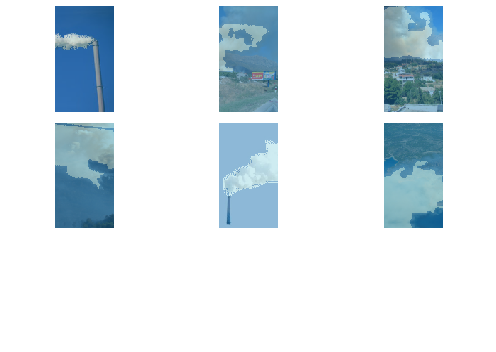

In [18]:
data.show_batch(rows=5, figsize=(7,5))


In [19]:
def acc(input, target):
    target = target.squeeze(1)
    return (input.argmax(dim=1)==target).float().mean()

metrics=acc


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


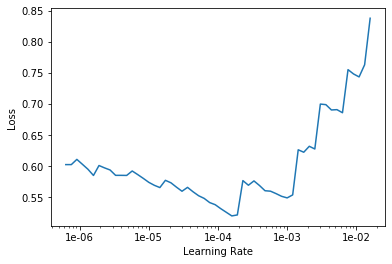

In [20]:
learn = unet_learner(data, models.resnet34, metrics=metrics, wd=0)
lr_find(learn)
learn.recorder.plot()

In [21]:
learn.fit_one_cycle(20, 0.5e-3)

epoch,train_loss,valid_loss,acc,time
0,0.548850,0.522192,0.770975,00:03
1,0.462950,0.449279,0.792024,00:02
2,0.411277,0.340976,0.852052,00:02
3,0.911548,3.908635,0.793719,00:02
4,0.802831,0.433528,0.816059,00:02
5,0.541467,0.261958,0.884509,00:02
6,0.398673,0.262157,0.883925,00:02
7,0.310994,0.232806,0.888811,00:02
8,0.277735,0.281499,0.871813,00:02
9,0.256593,0.262421,0.885646,00:02


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


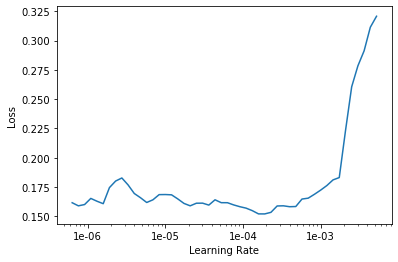

In [22]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()

In [23]:
learn.fit_one_cycle(10, slice(1e-5, 0.5e-4))

epoch,train_loss,valid_loss,acc,time
0,0.185530,0.197453,0.912363,00:02
1,0.172986,0.196785,0.913422,00:02
2,0.170276,0.195833,0.909886,00:02
3,0.163729,0.194261,0.914955,00:02
4,0.159767,0.208312,0.905320,00:02
5,0.158642,0.201801,0.910179,00:02
6,0.160798,0.197214,0.914488,00:02
7,0.154598,0.190099,0.918142,00:02
8,0.156265,0.196944,0.915272,00:02
9,0.145739,0.198440,0.912998,00:02


In [37]:
learn.save('stage-2')

In [54]:
learn = unet_learner(data, models.resnet34, metrics=metrics, wd=0)

learn.load('stage-2')

Learner(data=ImageDataBunch;

Train: LabelList (205 items)
x: SegItemListCustom
Image (3, 151, 83),Image (3, 151, 83),Image (3, 151, 83),Image (3, 151, 83),Image (3, 151, 83)
y: SegLabelListCustom
ImageSegment (1, 151, 83),ImageSegment (1, 151, 83),ImageSegment (1, 151, 83),ImageSegment (1, 151, 83),ImageSegment (1, 151, 83)
Path: /home/sahand/Smoke_detection/data/Smoke_segmentation/training;

Valid: LabelList (51 items)
x: SegItemListCustom
Image (3, 151, 83),Image (3, 151, 83),Image (3, 151, 83),Image (3, 151, 83),Image (3, 151, 83)
y: SegLabelListCustom
ImageSegment (1, 151, 83),ImageSegment (1, 151, 83),ImageSegment (1, 151, 83),ImageSegment (1, 151, 83),ImageSegment (1, 151, 83)
Path: /home/sahand/Smoke_detection/data/Smoke_segmentation/training;

Test: None, model=DynamicUnet(
  (layers): ModuleList(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_ru

In [55]:
test_names = get_image_files(test_images)
test_names[:3]

[PosixPath('/home/sahand/Smoke_detection/data/Smoke_segmentation/test/image_00057.jpg'),
 PosixPath('/home/sahand/Smoke_detection/data/Smoke_segmentation/test/image_00007.jpg'),
 PosixPath('/home/sahand/Smoke_detection/data/Smoke_segmentation/test/image_00034.jpg')]

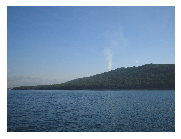

In [56]:
img_1 = open_image(test_names[0])
img_2 = open_image(test_names[1])
img_3 = open_image(test_names[2])
img_1.show()

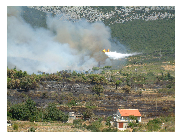

In [57]:
img_2.show()

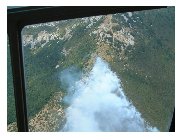

In [58]:
img_3.show()

In [59]:
predicted_mask_1 = learn.predict(img_1)[0]
predicted_mask_2 = learn.predict(img_2)[0]
predicted_mask_3 = learn.predict(img_3)[0]

In [60]:
predicted_mask_1.size


torch.Size([151, 83])

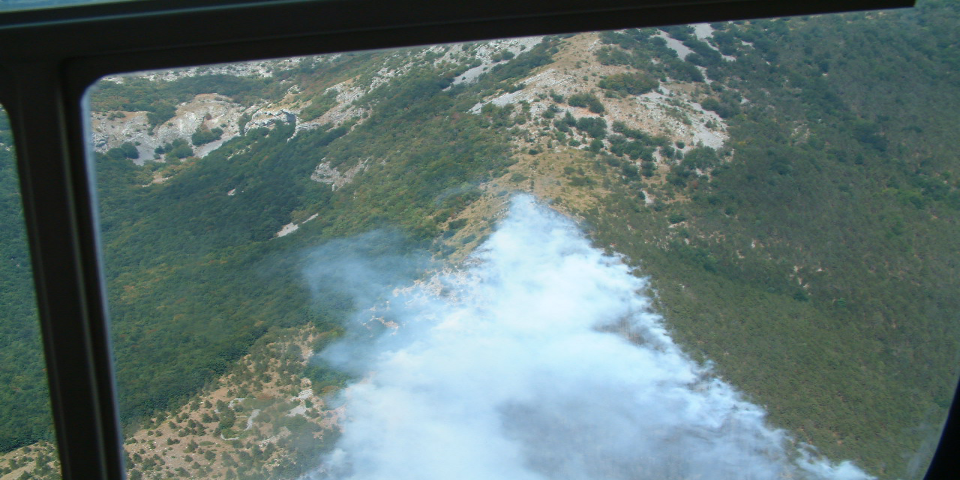

In [61]:
size= (3, 480, 960)
img_1.resize(size)
img_2.resize(size)
img_3.resize(size)

In [62]:
omdena_test_images='data/omdena_data/videos/Incendio_10_R_17072018_103000_jpeg'
test_names = get_image_files(omdena_test_images)

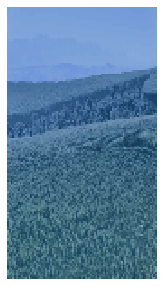

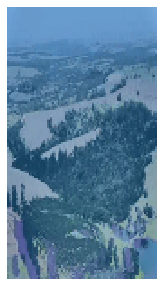

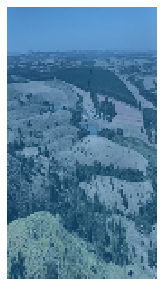

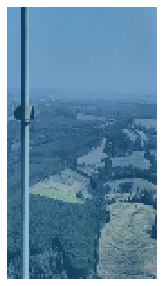

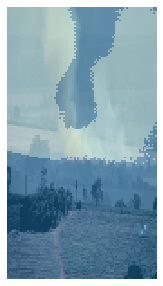

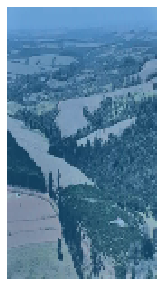

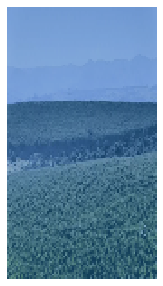

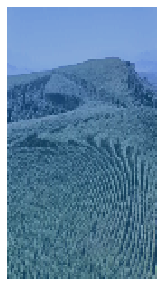

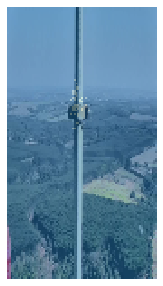

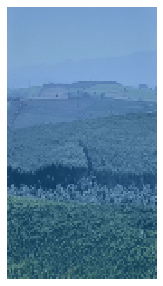

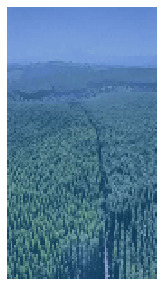

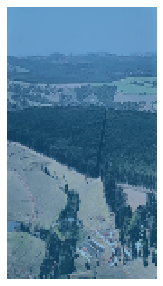

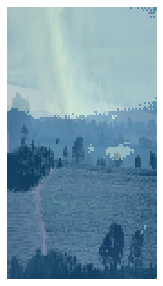

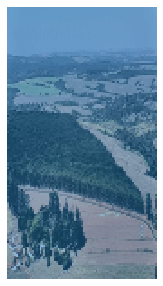

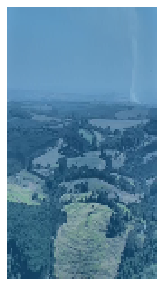

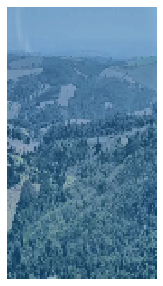

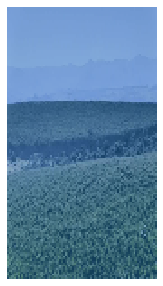

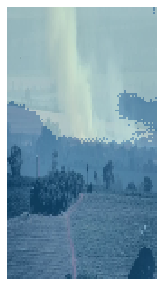

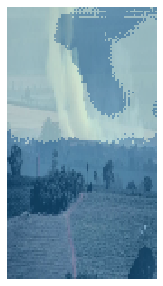

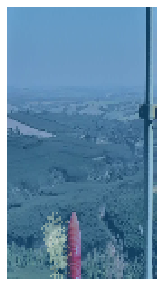

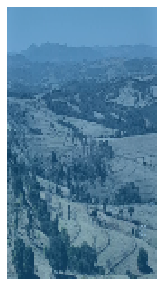

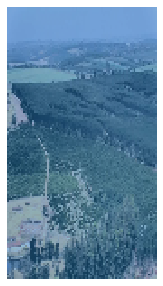

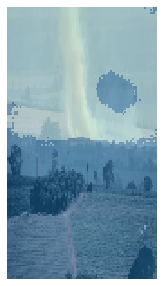

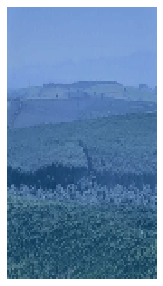

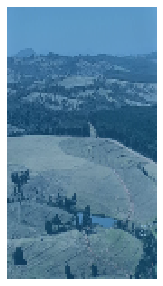

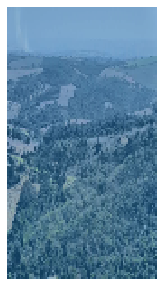

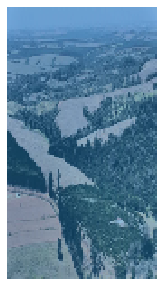

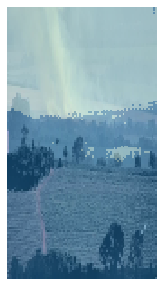

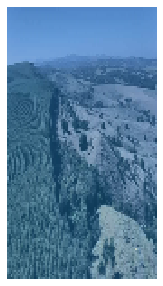

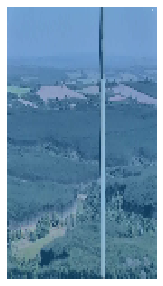

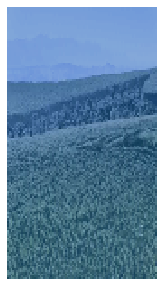

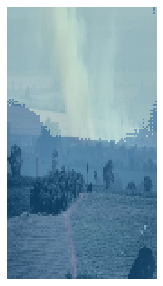

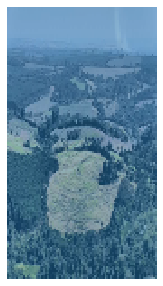

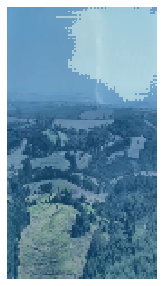

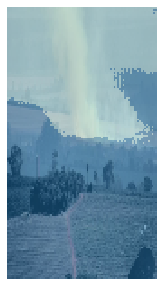

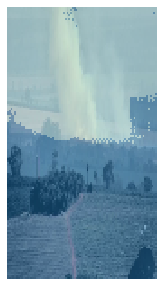

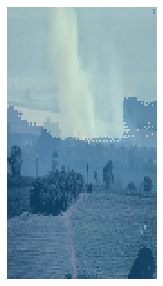

In [66]:
import warnings
warnings.filterwarnings("ignore")
predicted_masks=[]
for i in range(len(test_names)):
    img = open_image(test_names[i])
    predicted_mask=learn.predict(img)
    predicted_masks.append(predicted_mask)
    predicted_masks[0]
    img.resize(predicted_mask[0].shape)
    img.show(figsize=(5,5), y=predicted_mask[0])